# Notebook 1: E-GMD Dataset Exploration & Subsetting Strategy

**Objective:** Explore the structure and metadata of the Expanded Groove MIDI Dataset (E-GMD) to understand its characteristics and devise a strategy for creating a manageable, representative subset for model development.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import typing
import os
import shutil
from tqdm.notebook import tqdm
import librosa
import librosa.display
import pretty_midi
import random

In [2]:
# Configure plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# Define functions for Roland to simplified GM mapping conversion
def get_roland_to_simplified_category(pitch):
    """
    Convert Roland drum mapping to simplified drum categories.

    Args:
        pitch (int): MIDI pitch number in Roland mapping

    Returns:
        tuple: (new_pitch, category_name) with standardized pitch and category
    """
    # Define pitch mappings from Roland to simplified categories
    roland_to_simple = {
        # Kicks
        36: (36, "Kick"),

        # Snares
        38: (38, "Snare"),
        40: (38, "Snare"),  # Snare rim -> Snare
        37: (38, "Snare"),  # X-stick -> Snare

        # Toms
        48: (47, "Tom"),    # Tom 1 -> Tom
        50: (47, "Tom"),    # Tom 1 rim -> Tom
        45: (47, "Tom"),    # Tom 2 -> Tom
        47: (47, "Tom"),    # Tom 2 rim -> Tom
        43: (47, "Tom"),    # Tom 3 -> Tom
        58: (47, "Tom"),    # Tom 3 rim -> Tom

        # Hi-Hats
        46: (42, "HiHat"),  # HH Open -> HiHat
        26: (42, "HiHat"),  # HH Open Edge -> HiHat
        42: (42, "HiHat"),  # HH Closed -> HiHat
        22: (42, "HiHat"),  # HH Closed Edge -> HiHat
        44: (42, "HiHat"),  # HH Pedal -> HiHat

        # Crash Cymbals
        49: (49, "Crash"),  # Crash 1 -> Crash
        55: (49, "Crash"),  # Crash 1 Edge -> Crash
        57: (49, "Crash"),  # Crash 2 -> Crash
        52: (49, "Crash"),  # Crash 2 Edge -> Crash

        # Ride Cymbals
        51: (51, "Ride"),   # Ride -> Ride
        59: (51, "Ride"),   # Ride Edge -> Ride
        53: (51, "Ride")    # Ride Bell -> Ride
    }

    # Return the mapping or default to (pitch, "Unknown")
    return roland_to_simple.get(pitch, (pitch, f"Unknown ({pitch})"))

def get_drum_name_simplified(pitch):
    """
    Get simplified drum name for visualization purposes.

    Args:
        pitch (int): MIDI pitch number

    Returns:
        str: Simplified drum name
    """
    _, category = get_roland_to_simplified_category(pitch)
    return category

In [4]:
def convert_midi_to_simplified_mapping(midi_path, output_path):
    """
    Converts a MIDI file from Roland drum mapping to simplified GM drum mapping.

    Args:
        midi_path: Path to the source MIDI file
        output_path: Path to save the converted MIDI file

    Returns:
        bool: True if conversion was successful, False otherwise
    """
    try:
        # Load the MIDI file
        pm = pretty_midi.PrettyMIDI(str(midi_path))

        # Process each instrument
        for instrument in pm.instruments:
            if instrument.is_drum:
                # Create a new list for converted notes
                new_notes = []

                # Process each note
                for note in instrument.notes:
                    # Get the new pitch using our mapping function
                    new_pitch, _ = get_roland_to_simplified_category(note.pitch)

                    # Create a new note with the converted pitch
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=new_pitch,
                        start=note.start,
                        end=note.end
                    )
                    new_notes.append(new_note)

                # Replace the old notes with the new ones
                instrument.notes = new_notes

        # Save the modified MIDI file
        pm.write(str(output_path))
        return True

    except Exception as e:
        print(f"Error converting MIDI file: {e}")
        return False

## 2. Define Dataset Path

Specify the relative path to the root directory where the E-GMD dataset was extracted.

In [5]:
# Define the path relative to the notebooks directory
DATASET_PATH: Path = Path("../data/raw/e-gmd-v1.0.0/")

In [6]:
# Verify the path exists
if not DATASET_PATH.exists():
    print(f"Error: Dataset path not found at {DATASET_PATH.resolve()}")
else:
    print(f"Dataset path found: {DATASET_PATH.resolve()}")

Dataset path found: /home/ivan/uni/APPSA/DrumScribe-AI/data/raw/e-gmd-v1.0.0


## 3. Load Metadata

Load the main metadata file (`e-gmd-v1.0.0.csv`) into a pandas DataFrame.

In [7]:
METADATA_FILE: Path = DATASET_PATH / "e-gmd-v1.0.0.csv"

In [8]:
if not METADATA_FILE.exists():
    print(f"Error: Metadata file not found at {METADATA_FILE.resolve()}")
else:
    print(f"Loading metadata from: {METADATA_FILE.resolve()}")
    try:
        metadata_df: pd.DataFrame = pd.read_csv(METADATA_FILE)
        print("Metadata loaded successfully.")
    except Exception as e:
        print(f"Error loading metadata: {e}")
        metadata_df = pd.DataFrame()  # Assign empty df on error

Loading metadata from: /home/ivan/uni/APPSA/DrumScribe-AI/data/raw/e-gmd-v1.0.0/e-gmd-v1.0.0.csv
Metadata loaded successfully.


## 4. Explore Metadata

Perform initial exploration of the metadata to understand the available fields, data types, and distributions.

### 4.1. Basic Information

In [9]:
if not metadata_df.empty:
    print("First 5 rows:")
    display(metadata_df.head())
    print("\nDataFrame Info:")
    metadata_df.info()
else:
    print("Metadata DataFrame is empty, skipping exploration.")

First 5 rows:


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Acoustic Kit
1,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,JingleStacks (2nd Hi-Hat)
2,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Studio (Live Room)
3,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Classic Rock
4,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Jazz Funk



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45537 entries, 0 to 45536
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   drummer         45537 non-null  object 
 1   session         45537 non-null  object 
 2   id              45537 non-null  object 
 3   style           45537 non-null  object 
 4   bpm             45537 non-null  int64  
 5   beat_type       45537 non-null  object 
 6   time_signature  45537 non-null  object 
 7   duration        45537 non-null  float64
 8   split           45537 non-null  object 
 9   midi_filename   45537 non-null  object 
 10  audio_filename  45537 non-null  object 
 11  kit_name        45537 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 4.2+ MB


### 4.2. Descriptive Statistics (Numerical Columns)

In [10]:
if not metadata_df.empty:
    print("Descriptive Statistics:")
    display(metadata_df.describe())
else:
    print("Metadata DataFrame is empty, skipping statistics.")

Descriptive Statistics:


,bpm,duration
count,45537.000000,45537.000000
mean,109.805477,35.140608
std,23.992195,66.746390
min,50.000000,0.669841
25%,95.000000,2.068957
50%,110.000000,3.502789
75%,125.000000,36.179592
max,290.000000,611.754989


### 4.3. Value Counts (Categorical Columns)

Examine the distribution of key categorical features like `drummer`, `session`, `style`, and `time_signature`.

In [11]:
if not metadata_df.empty:
    categorical_cols: typing.List[str] = [
        "drummer",
        "session",
        "style",
        "time_signature",
        "split",
    ]
    for col in categorical_cols:
        if col in metadata_df.columns:
            print(f"\n--- Value Counts for '{col}' ---")
            print(metadata_df[col].value_counts())
        else:
            print(f"\nColumn '{col}' not found in metadata.")
else:
    print("Metadata DataFrame is empty, skipping value counts.")


--- Value Counts for 'drummer' ---
drummer
drummer1     20726
drummer7     14018
drummer3      4171
drummer5      2322
drummer8      1591
drummer9      1290
drummer6       645
drummer10      387
drummer4       387
Name: count, dtype: int64

--- Value Counts for 'session' ---
session
drummer1/session1        11352
drummer1/session2         8213
drummer7/session3         6364
drummer7/session2         5633
drummer3/session1         2150
drummer3/session2         2021
drummer7/session1         1591
drummer9/session1         1290
drummer8/session1         1161
drummer5/session2         1032
drummer5/session1          860
drummer1/session3          731
drummer1/eval_session      430
drummer8/eval_session      430
drummer7/eval_session      430
drummer5/eval_session      430
drummer10/session1         387
drummer4/session1          387
drummer6/session3          301
drummer6/session1          215
drummer6/session2          129
Name: count, dtype: int64

--- Value Counts for 'style' ---
styl

### 4.4. Distribution Visualization (Numerical Columns)

Visualize the distribution of numerical columns like `tempo`.

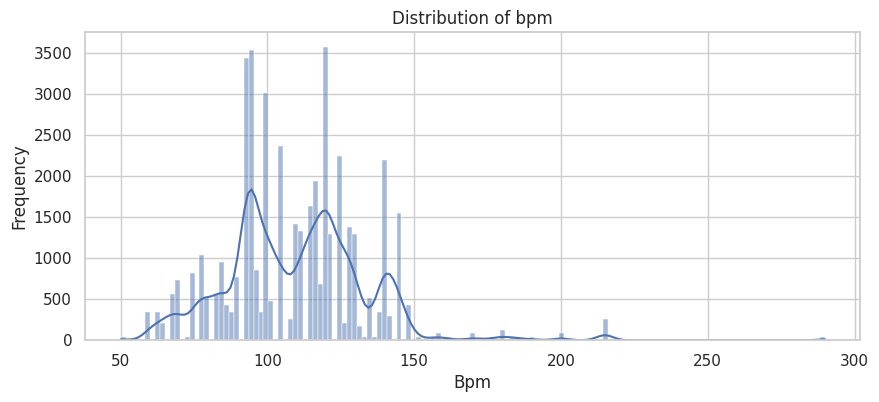

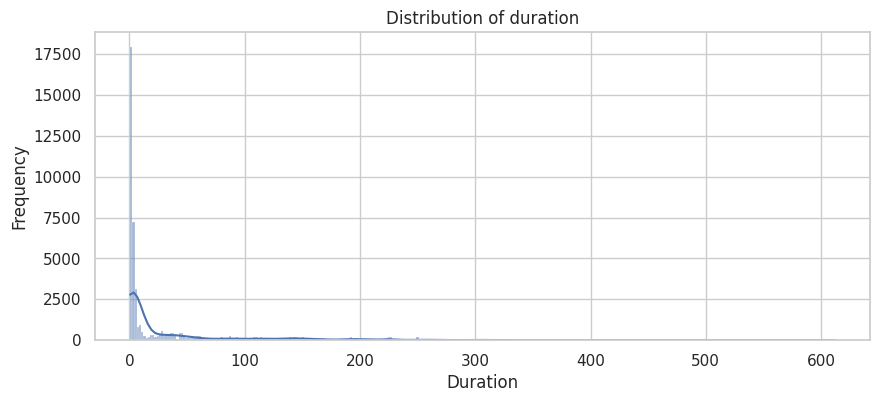

In [12]:
if not metadata_df.empty:
    numerical_cols: typing.List[str] = ["bpm", "duration"]
    for col in numerical_cols:
        if col in metadata_df.columns:
            plt.figure(figsize=(10, 4))
            sns.histplot(metadata_df[col], kde=True)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col.capitalize())
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"\nColumn '{col}' not found for visualization.")
else:
    print("Metadata DataFrame is empty, skipping visualizations.")

## 5. Propose Stratification Strategy

Based on the metadata exploration above, particularly the value counts for categorical columns, propose a strategy for stratified sampling to create a balanced 10% subset of the data. Consider which column(s) would be most suitable for stratification to ensure the subset represents the diversity of the full dataset (e.g., across different drummers, styles, tempos).

**Proposed Strategy:**

*   Based on the metadata exploration (section 4), the `drummer` column provides a good basis for stratification, ensuring representation from different players. The `style` column has many categories, some with very few samples, making it less ideal for primary stratification of a small subset.
*   **Primary Stratification Column:** `drummer`
*   **Reasoning:** Ensures the subset reflects the diversity of players present in the full dataset. Each drummer likely has a distinct playing style and kit setup.
*   **Target Subset Size:** ~10% of the total dataset.

We will proceed with implementing stratified sampling based on the `drummer` column.

## 6. Implement Subset Extraction Pipeline

Now, we implement the stratified sampling based on the `drummer` column to create a 10% subset. We will then copy the corresponding audio and MIDI files to a new directory and save the subset's metadata.

In [13]:
# Ensure metadata_df is loaded and not empty before proceeding
if "metadata_df" in locals() and not metadata_df.empty:
    print("Performing stratified sampling based on 'drummer'...")
    # Group by drummer and sample 10% from each group
    df_subset = metadata_df.groupby("drummer", group_keys=False).sample(
        frac=0.1, random_state=42
    )

    print("\nSubset created. First 5 rows:")
    display(df_subset.head())

    print(f"\nShape of the subset DataFrame: {df_subset.shape}")
else:
    print("Metadata DataFrame not loaded or empty. Skipping subset creation.")
    df_subset = pd.DataFrame()  # Assign empty df if metadata wasn't loaded

Performing stratified sampling based on 'drummer'...

Subset created. First 5 rows:


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
20236,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion
10135,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock
42297,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress)
11515,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple
42499,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal



Shape of the subset DataFrame: (4554, 12)


In [14]:
# Verify stratification by comparing drummer distributions
if not df_subset.empty:
    print("Comparing drummer distribution (Original vs Subset):\n")

    original_counts = metadata_df["drummer"].value_counts(normalize=True).sort_index()
    subset_counts = df_subset["drummer"].value_counts(normalize=True).sort_index()

    comparison_df = pd.DataFrame(
        {"Original (%)": original_counts * 100, "Subset (%)": subset_counts * 100}
    )
    comparison_df["Difference (%)"] = (
        comparison_df["Subset (%)"] - comparison_df["Original (%)"]
    )

    display(comparison_df.style.format("{:.2f}%"))

    # Check if proportions are roughly similar (allowing for sampling variance)
    if comparison_df["Difference (%)"].abs().max() < 5:  # Allow up to 5% difference
        print("\nStratification appears successful (proportions are similar).")
    else:
        print(
            "\nWarning: Stratification proportions differ significantly. Check sampling."
        )

else:
    print("Subset DataFrame is empty. Skipping stratification verification.")

Comparing drummer distribution (Original vs Subset):



,Original (%),Subset (%),Difference (%)
drummer,,,
drummer1,45.51%,45.52%,0.01%
drummer10,0.85%,0.86%,0.01%
drummer3,9.16%,9.16%,-0.00%
drummer4,0.85%,0.86%,0.01%
drummer5,5.10%,5.09%,-0.00%
drummer6,1.42%,1.41%,-0.01%
drummer7,30.78%,30.79%,0.00%
drummer8,3.49%,3.49%,-0.00%
drummer9,2.83%,2.83%,-0.00%



Stratification appears successful (proportions are similar).


### 6.1. Create Subset Directory and Copy Files

Define the path for the subset data and create the necessary directory structure. Then, iterate through the subset metadata, copying the corresponding audio (`.wav`) and MIDI (`.mid`) files from the original dataset path to the new subset path, maintaining the `split/drummer/session/style` structure. We use `shutil.copy2` to preserve metadata and `tqdm` for progress tracking.

In [15]:
# Define subset path relative to the project root (notebooks directory's parent)
SUBSET_PATH: Path = Path("../data/subset/")
DATASET_PATH: Path = Path("../data/raw/e-gmd-v1.0.0/")

if not df_subset.empty:
    print(f"Creating subset directory at: {SUBSET_PATH.resolve()}")
    os.makedirs(SUBSET_PATH, exist_ok=True)

    print("Copying files to subset directory...")
    copied_files_count = 0
    skipped_files_count = 0

    # First, let's try to detect the actual dataset structure
    # by finding one file from the metadata to see where it's located
    found_structure = False
    structure_pattern = None

    # Sample a few rows to find the structure
    sample_rows = df_subset.head(5)

    for _, row in sample_rows.iterrows():
        audio_filename = row["audio_filename"]
        just_filename = os.path.basename(audio_filename)

        # Try different path patterns
        patterns = [
            # Pattern 1: Original assumption - DATASET_PATH / split / audio_filename
            {
                "pattern": "split/full_path",
                "path": DATASET_PATH / row["split"] / audio_filename,
            },
            # Pattern 2: Direct drummer/session folders
            {"pattern": "direct_path", "path": DATASET_PATH / audio_filename},
            # Pattern 3: Just the filename portion in split directory
            {
                "pattern": "split/filename",
                "path": DATASET_PATH / row["split"] / just_filename,
            },
            # Pattern 4: Drummer directory then filename
            {
                "pattern": "drummer/filename",
                "path": DATASET_PATH / row["drummer"] / just_filename,
            },
        ]

        for pattern_info in patterns:
            if pattern_info["path"].exists():
                found_structure = True
                structure_pattern = pattern_info["pattern"]
                print(f"Found dataset structure: {structure_pattern}")
                print(f"Example file: {pattern_info['path']}")
                break

        if found_structure:
            break

    if not found_structure:
        print("Could not detect dataset structure. Trying recursive search...")
        # Last resort: try to find files by recursive glob search
        sample_filename = just_filename
        matches = list(DATASET_PATH.glob(f"**/{sample_filename}"))
        if matches:
            structure_pattern = "recursive_search"
            print(f"Found files using recursive search. Example: {matches[0]}")
        else:
            print("ERROR: Could not find any matching files in the dataset directory.")
            print(
                "Please check that the dataset is correctly extracted and file paths in metadata are accurate."
            )

    # Function to find a file based on detected structure
    def find_file_path(row, filename_field):
        filename = row[filename_field]
        just_name = os.path.basename(filename)

        if structure_pattern == "split/full_path":
            return DATASET_PATH / row["split"] / filename
        elif structure_pattern == "direct_path":
            return DATASET_PATH / filename
        elif structure_pattern == "split/filename":
            return DATASET_PATH / row["split"] / just_name
        elif structure_pattern == "drummer/filename":
            return DATASET_PATH / row["drummer"] / just_name
        elif structure_pattern == "recursive_search":
            # For recursive search, we'll need to search each time
            matches = list(DATASET_PATH.glob(f"**/{just_name}"))
            return matches[0] if matches else None
        else:
            # Fallback to original assumption
            return DATASET_PATH / row["split"] / filename

    # Use tqdm for progress bar
    for index, row in tqdm(
        df_subset.iterrows(), total=df_subset.shape[0], desc="Copying files"
    ):
        # Find source files using the detected structure
        source_audio_path = find_file_path(row, "audio_filename")
        source_midi_path = find_file_path(row, "midi_filename")

        # Construct target paths, maintaining structure within SUBSET_PATH
        target_audio_path: Path = SUBSET_PATH / row["split"] / row["audio_filename"]
        target_midi_path: Path = SUBSET_PATH / row["split"] / row["midi_filename"]

        # Create necessary subdirectories in the target path
        target_audio_dir: Path = target_audio_path.parent
        target_midi_dir: Path = target_midi_path.parent
        os.makedirs(target_audio_dir, exist_ok=True)
        os.makedirs(target_midi_dir, exist_ok=True)

        # Copy files if they exist, using copy2 to preserve metadata for audio
        # and converting MIDI to simplified mapping
        success = True
        try:
            if source_audio_path and source_audio_path.exists():
                shutil.copy2(source_audio_path, target_audio_path)
            else:
                print(f"Warning: Source audio file not found: {source_audio_path}")
                success = False

            if source_midi_path and source_midi_path.exists():
                # Convert MIDI to simplified GM mapping
                if convert_midi_to_simplified_mapping(source_midi_path, target_midi_path):
                    print(f"Successfully converted MIDI to simplified mapping: {target_midi_path}")
                else:
                    # Fallback to direct copy if conversion fails
                    print(f"Warning: MIDI conversion failed, copying original file")
                    shutil.copy2(source_midi_path, target_midi_path)
            else:
                print(f"Warning: Source MIDI file not found: {source_midi_path}")
                success = False
        except Exception as e:
            print(f"Error processing files for index {index}: {e}")
            success = False

        if success:
            copied_files_count += 1
        else:
            skipped_files_count += 1

    print("\nFile copying complete.")
    print(f"Successfully copied pairs (audio+midi): {copied_files_count}")
    print(f"Skipped files/pairs due to errors or missing source: {skipped_files_count}")

    # Verify files exist in the subset directory
    subset_audio_count = len(list(SUBSET_PATH.glob("**/*.wav")))
    subset_midi_count = len(list(SUBSET_PATH.glob("**/*.mid*")))
    print(
        f"\nFound {subset_audio_count} audio files and {subset_midi_count} MIDI files in subset directory"
    )

    if subset_audio_count == 0 and subset_midi_count == 0:
        print("WARNING: No files were copied! Check dataset paths and structure.")
else:
    print("Subset DataFrame is empty. Skipping file copying.")

Creating subset directory at: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset
Copying files to subset directory...
Found dataset structure: direct_path
Example file: ../data/raw/e-gmd-v1.0.0/drummer1/session2/80_punk_144_fill_4-4_37.wav


Copying files:   0%|          | 0/4554 [00:00<?, ?it/s]

Successfully converted MIDI to simplified mapping: ../data/subset/train/drummer1/session2/80_punk_144_fill_4-4_37.midi
Successfully converted MIDI to simplified mapping: ../data/subset/train/drummer1/session1/224_rock-halftime_140_fill_4-4_43.midi
Successfully converted MIDI to simplified mapping: ../data/subset/validation/drummer1/session2/149_gospel_120_fill_4-4_41.midi
Successfully converted MIDI to simplified mapping: ../data/subset/train/drummer1/session1/260_funk-purdieshuffle_130_fill_4-4_52.midi
Successfully converted MIDI to simplified mapping: ../data/subset/validation/drummer1/session2/198_rock_115_fill_4-4_24.midi
Successfully converted MIDI to simplified mapping: ../data/subset/test/drummer1/session2/119_afrocuban-bembe_122_fill_4-4_22.midi
Successfully converted MIDI to simplified mapping: ../data/subset/train/drummer1/session1/66_jazz_125_fill_4-4_6.midi
Successfully converted MIDI to simplified mapping: ../data/subset/train/drummer1/session1/231_rock-halftime_140_fill_4

### 6.2. Save Subset Metadata

Finally, save the `df_subset` DataFrame containing the metadata for the newly created subset to a CSV file within the subset directory.

In [16]:
if not df_subset.empty:
    subset_metadata_path: Path = SUBSET_PATH / "subset_metadata.csv"
    print(f"Saving subset metadata to: {subset_metadata_path.resolve()}")
    try:
        df_subset.to_csv(subset_metadata_path, index=False)
        print("Subset metadata saved successfully.")
    except Exception as e:
        print(f"Error saving subset metadata: {e}")
else:
    print("Subset DataFrame is empty. Skipping metadata saving.")

Saving subset metadata to: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset/subset_metadata.csv
Subset metadata saved successfully.


## 7. Create Train/Validation/Test Splits

Now that we have the subset metadata, we'll split it into training (70%), validation (15%), and test (15%) sets. We will stratify the split based on the `drummer` column to ensure each drummer is proportionally represented in all sets.

### 7.1. Load Subset Metadata (if needed)

First, let's load the subset metadata file we created in the previous step.

In [17]:
import pandas as pd
from pathlib import Path
import typing

# Define path to subset metadata
SUBSET_METADATA_PATH: Path = Path("../data/subset/subset_metadata.csv")

# Load the dataframe
if SUBSET_METADATA_PATH.exists():
    print(f"Loading subset metadata from: {SUBSET_METADATA_PATH.resolve()}")
    try:
        df_subset: pd.DataFrame = pd.read_csv(SUBSET_METADATA_PATH)
        print("Subset metadata loaded successfully.")
        display(df_subset.head())
    except Exception as e:
        print(f"Error loading subset metadata: {e}")
        df_subset = pd.DataFrame()  # Assign empty df on error
else:
    print(f"Error: Subset metadata file not found at {SUBSET_METADATA_PATH.resolve()}")
    df_subset = pd.DataFrame()

Loading subset metadata from: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset/subset_metadata.csv
Subset metadata loaded successfully.


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
0,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion
1,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock
2,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress)
3,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple
4,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal


### 7.2. Perform Stratified Split

We'll use `sklearn.model_selection.train_test_split` twice to achieve the 70/15/15 split, stratified by `drummer`.

In [18]:
from sklearn.model_selection import train_test_split

RANDOM_STATE: int = 42
TRAIN_SIZE: float = 0.70  # 70% for training
VAL_TEST_SIZE: float = 0.30  # Remaining 30% for validation + test
VAL_SIZE_REL_TEMP: float = (
    0.50  # 50% of the temp set for validation (0.30 * 0.50 = 0.15 of total)
)
TEST_SIZE_REL_TEMP: float = (
    0.50  # 50% of the temp set for test (0.30 * 0.50 = 0.15 of total)
)

if not df_subset.empty:
    print("Performing train/validation/test split...")

    # Ensure the index is unique if it's not already (needed for mapping back)
    if not df_subset.index.is_unique:
        df_subset = df_subset.reset_index(drop=True)

    # Features (X) and target/stratification column (y)
    X = df_subset.index  # Use index to easily map back
    y = df_subset["drummer"]

    # First split: Train (70%) and Temp (30%)
    X_train_idx, X_temp_idx, y_train, y_temp = train_test_split(
        X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y, shuffle=True
    )

    # Second split: Validation (15%) and Test (15%) from Temp (30%)
    # Need to stratify based on the drummer labels corresponding to the temp indices
    y_temp_stratify = df_subset.loc[X_temp_idx, "drummer"]
    X_val_idx, X_test_idx, y_val, y_test = train_test_split(
        X_temp_idx,
        y_temp_stratify,
        train_size=VAL_SIZE_REL_TEMP,  # Relative to the temp set size
        random_state=RANDOM_STATE,
        stratify=y_temp_stratify,
        shuffle=True,
    )

    print("Splitting complete.")
    print(f"Train set size: {len(X_train_idx)}")
    print(f"Validation set size: {len(X_val_idx)}")
    print(f"Test set size: {len(X_test_idx)}")

else:
    print("Subset DataFrame is empty. Skipping split.")

Performing train/validation/test split...
Splitting complete.
Train set size: 3187
Validation set size: 683
Test set size: 684


### 7.3. Add 'split' Column to DataFrame

Now, add a column to the original `df_subset` indicating which split each row belongs to.

In [19]:
if not df_subset.empty and "X_train_idx" in locals():
    # Add the 'split' column
    df_subset["split_set"] = "unknown"  # Initialize column
    df_subset.loc[X_train_idx, "split_set"] = "train"
    df_subset.loc[X_val_idx, "split_set"] = "validation"
    df_subset.loc[X_test_idx, "split_set"] = "test"

    print("Added 'split_set' column to the DataFrame.")
    display(df_subset.head())
else:
    print(
        "Split indices not available or DataFrame empty. Skipping adding 'split_set' column."
    )

Added 'split_set' column to the DataFrame.


,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name,split_set
0,drummer1,drummer1/session2,drummer1/session2/80,punk,144,fill,4-4,1.661678,train,drummer1/session2/80_punk_144_fill_4-4_37.midi,drummer1/session2/80_punk_144_fill_4-4_37.wav,Live Fusion,train
1,drummer1,drummer1/session1,drummer1/session1/224,rock/halftime,140,fill,4-4,1.714286,train,drummer1/session1/224_rock-halftime_140_fill_4...,drummer1/session1/224_rock-halftime_140_fill_4...,Funk Rock,test
2,drummer1,drummer1/session2,drummer1/session2/149,gospel,120,fill,4-4,1.853129,validation,drummer1/session2/149_gospel_120_fill_4-4_41.midi,drummer1/session2/149_gospel_120_fill_4-4_41.wav,Cassette (Lo-Fi Compress),train
3,drummer1,drummer1/session1,drummer1/session1/260,funk/purdieshuffle,130,fill,4-4,1.846145,train,drummer1/session1/260_funk-purdieshuffle_130_f...,drummer1/session1/260_funk-purdieshuffle_130_f...,909 Simple,train
4,drummer1,drummer1/session2,drummer1/session2/198,rock,115,fill,4-4,1.726984,validation,drummer1/session2/198_rock_115_fill_4-4_24.midi,drummer1/session2/198_rock_115_fill_4-4_24.wav,Heavy Metal,test


### 7.4. Verify Split Proportions and Stratification

Let's check the counts for each split and the distribution of drummers within each split.

--- Split Set Value Counts ---
split_set
train         69.982433
test          15.019763
validation    14.997804
Name: proportion, dtype: float64

--- Drummer Distribution per Split Set ---


split_set,test,train,validation
drummer,,,
drummer1,45.47%,45.53%,45.53%
drummer10,0.88%,0.85%,0.88%
drummer3,9.21%,9.16%,9.08%
drummer4,0.88%,0.85%,0.88%
drummer5,5.12%,5.11%,4.98%
drummer6,1.32%,1.41%,1.46%
drummer7,30.85%,30.78%,30.75%
drummer8,3.51%,3.48%,3.51%
drummer9,2.78%,2.82%,2.93%


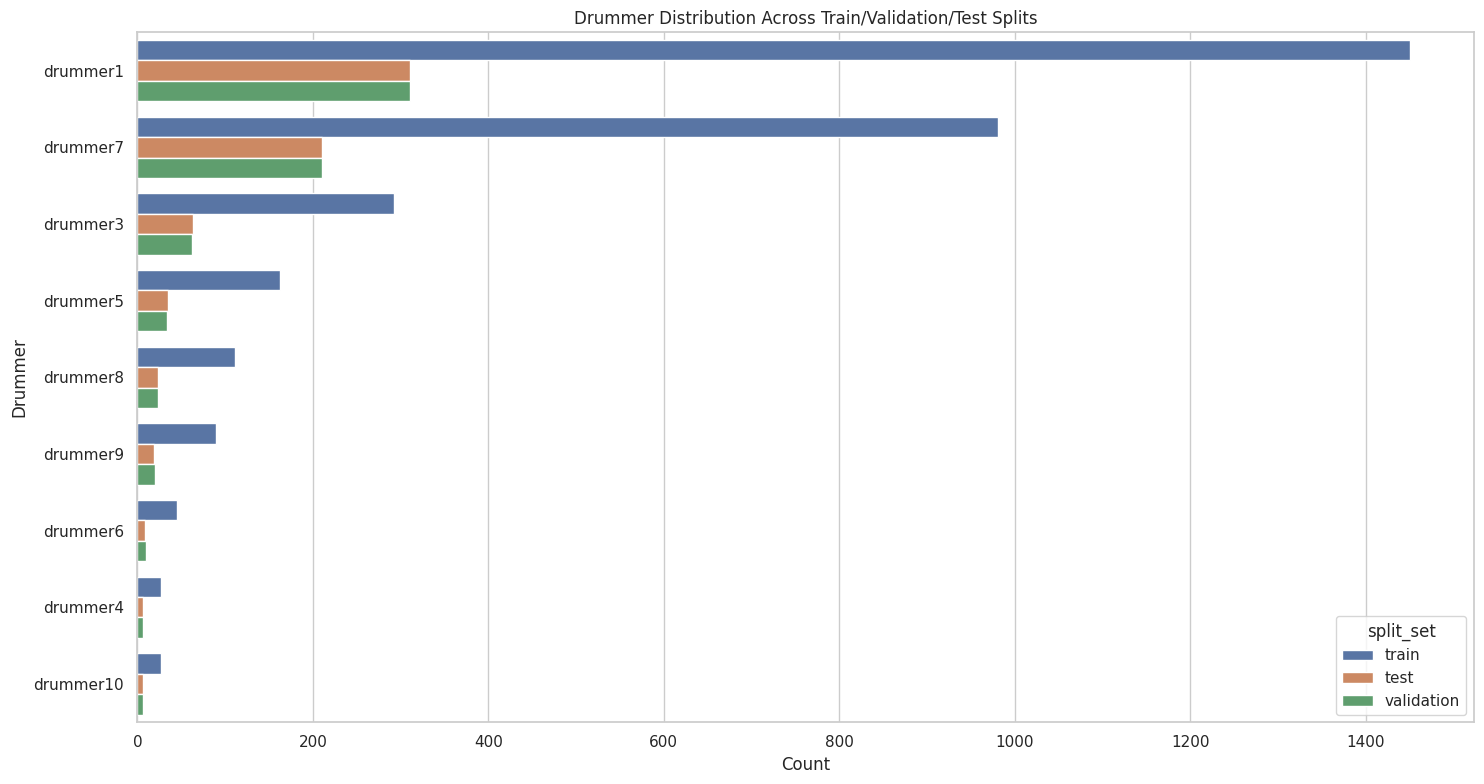


Split proportions are within tolerance.

Visually inspect the table and plot above to confirm drummer distribution is similar across splits.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

if not df_subset.empty and "split_set" in df_subset.columns:
    print("--- Split Set Value Counts ---")
    split_counts = df_subset["split_set"].value_counts(normalize=True) * 100
    print(split_counts)

    print("\n--- Drummer Distribution per Split Set ---")
    # Calculate drummer distribution within each split
    drummer_dist = (
        df_subset.groupby("split_set")["drummer"]
        .value_counts(normalize=True)
        .unstack(level=0)
        * 100
    )

    # Display the distribution table
    display(
        drummer_dist.style.format("{:.2f}%").background_gradient(cmap="viridis", axis=1)
    )

    # Optional: Visualize the distribution
    plt.figure(figsize=(15, 8))
    sns.countplot(
        data=df_subset,
        y="drummer",
        hue="split_set",
        order=df_subset["drummer"].value_counts().index,
    )
    plt.title("Drummer Distribution Across Train/Validation/Test Splits")
    plt.xlabel("Count")
    plt.ylabel("Drummer")
    plt.tight_layout()
    plt.show()

    # Check if proportions are roughly correct
    target_proportions = {"train": 70.0, "validation": 15.0, "test": 15.0}
    all_proportions_ok = True
    for split_name, target_prop in target_proportions.items():
        actual_prop = split_counts.get(split_name, 0)
        if not np.isclose(actual_prop, target_prop, atol=2.0):  # Allow 2% tolerance
            print(
                f"Warning: Proportion for '{split_name}' ({actual_prop:.2f}%) is off target ({target_prop:.1f}%)."
            )
            all_proportions_ok = False

    if all_proportions_ok:
        print("\nSplit proportions are within tolerance.")

    # Check stratification (visual inspection or more rigorous statistical tests could be added)
    print(
        "\nVisually inspect the table and plot above to confirm drummer distribution is similar across splits."
    )

else:
    print(
        "Subset DataFrame is empty or 'split_set' column not found. Skipping verification."
    )

### 7.5. Save Updated Subset Metadata

Finally, save the `df_subset` DataFrame, now including the `split_set` column, back to the CSV file, overwriting the previous version.

In [21]:
if not df_subset.empty and "split_set" in df_subset.columns:
    print(f"Saving updated subset metadata to: {SUBSET_METADATA_PATH.resolve()}")
    try:
        df_subset.to_csv(SUBSET_METADATA_PATH, index=False)
        print("Updated subset metadata saved successfully.")
    except Exception as e:
        print(f"Error saving updated subset metadata: {e}")
else:
    print(
        "Subset DataFrame is empty or 'split_set' column missing. Skipping metadata saving."
    )

Saving updated subset metadata to: /home/ivan/uni/APPSA/DrumScribe-AI/data/subset/subset_metadata.csv
Updated subset metadata saved successfully.


## 8. Visualize Subset Examples

Let's visualize a couple of random examples from our subset to get a feel for the audio and corresponding MIDI drum patterns.

In [ ]:
SUBSET_METADATA_PATH: Path = Path("../data/subset/subset_metadata.csv")
SUBSET_DATA_DIR: Path = Path("../data/subset/")

if "df_subset" not in locals() or df_subset.empty:
    if SUBSET_METADATA_PATH.exists():
        print(f"Reloading subset metadata from: {SUBSET_METADATA_PATH.resolve()}")
        try:
            df_subset: pd.DataFrame = pd.read_csv(SUBSET_METADATA_PATH)
            print("Subset metadata reloaded successfully.")
        except Exception as e:
            print(f"Error reloading subset metadata: {e}")
            df_subset = pd.DataFrame()  # Assign empty df on error
    else:
        print(
            f"Error: Subset metadata file not found at {SUBSET_METADATA_PATH.resolve()}"
        )
        df_subset = pd.DataFrame()


def plot_drum_piano_roll(
    pm: pretty_midi.PrettyMIDI,
    start_pitch: int = 35,
    end_pitch: int = 52,
    fs: int = 100,
):
    """
    Plots a piano roll representation for simplified drum notes with distinct colors.

    Args:
        pm (pretty_midi.PrettyMIDI): The PrettyMIDI object
        start_pitch (int): The lowest MIDI pitch to include (default: 35)
        end_pitch (int): The highest MIDI pitch to include (default: 52)
        fs (int): Sampling frequency for the piano roll grid
    """
    # Define colors for each drum type
    drum_colors = {
        36: 'red',      # Kick
        38: 'blue',     # Snare
        42: 'green',    # HiHat
        47: 'purple',   # Tom
        49: 'orange',   # Crash
        51: 'yellow',   # Ride
    }

    # Find the drum instrument
    drum_instrument = None
    for instrument in pm.instruments:
        if instrument.is_drum:
            drum_instrument = instrument
            break

    if drum_instrument is None or len(drum_instrument.notes) == 0:
        print("No drum track found or the drum track has no notes.")
        duration = pm.get_end_time()
        plt.gca().set_xlim([0, duration])
        plt.gca().set_ylim([start_pitch, end_pitch])
        plt.title("Drum Piano Roll (No notes found)")
        return

    # Print notes found
    pitch_counts = {}
    for note in drum_instrument.notes:
        if start_pitch <= note.pitch <= end_pitch:
            if note.pitch not in pitch_counts:
                pitch_counts[note.pitch] = 0
            pitch_counts[note.pitch] += 1

    if pitch_counts:
        print("Detected drum hits:")
        for pitch, count in sorted(pitch_counts.items()):
            drum_name = get_drum_name_simplified(pitch)
            print(f"  {drum_name} (pitch {pitch}): {count} hits")

    # Create a clean figure with proper time axis
    duration = pm.get_end_time()
    plt.gca().set_xlim([0, duration])
    plt.gca().set_ylim([start_pitch - 0.5, end_pitch + 0.5])

    # Plot each note as a colored line for its duration
    for note in drum_instrument.notes:
        if start_pitch <= note.pitch <= end_pitch:
            # Map to simplified pitch
            simplified_pitch, _ = get_roland_to_simplified_category(note.pitch)

            # Get color (default to gray for unknown pitches)
            color = drum_colors.get(simplified_pitch, 'gray')

            # Plot horizontal line for note duration
            plt.hlines(
                y=simplified_pitch,
                xmin=note.start,
                xmax=note.end,
                colors=color,
                linewidth=4
            )

    # Set ticks and labels for simplified drum mapping
    simplified_drums = {
        36: "Kick",
        38: "Snare",
        42: "HiHat",
        47: "Tom",
        49: "Crash",
        51: "Ride"
    }

    # Create ticks at these pitches
    plt.yticks(list(simplified_drums.keys()))

    # Add drum names as text labels
    for pitch, name in simplified_drums.items():
        if start_pitch <= pitch <= end_pitch:
            plt.text(-0.5, pitch, name, ha="right", va="center")

    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=drum_colors[pitch], lw=4, label=name)
        for pitch, name in simplified_drums.items()
        if pitch in drum_colors
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.ylabel("Drum Type")
    plt.xlabel("Time (s)")
    plt.title("Drum Piano Roll (Simplified Mapping)")
    plt.grid(True, alpha=0.3)


--- Visualizing Example 4553 ---
Drummer: drummer9, Style: rock, Tempo: 100.00 BPM, Split: train
Audio Path: ../data/subset/train/drummer9/session1/5_rock_100_beat_4-4_23.wav
MIDI Path: ../data/subset/train/drummer9/session1/5_rock_100_beat_4-4_23.midi

--- DETAILED MIDI ANALYSIS: 5_rock_100_beat_4-4_23.midi ---
✓ MIDI loaded successfully
  • Duration: 71.78 seconds
  • Time signature: [TimeSignature(numerator=4, denominator=4, time=0.0)]
  • Estimated tempo: 204.95 BPM
  • Resolution: 480 ticks per beat

INSTRUMENT TRACKS (1):

Track 0: 🥁 DRUM, Program: 0, Name: 'Blue Ridge'
  • Contains 548 notes
  • Pitch range: 36 to 51
  • Most common pitches:
    - Pitch 51 (Ride Cymbal 1): 197 notes
    - Pitch 38 (Acoustic Snare): 160 notes
    - Pitch 36 (Bass Drum 1): 128 notes
    - Pitch 42 (Closed Hi Hat): 28 notes
    - Pitch 47 (Low-Mid Tom): 25 notes
Audio loaded: duration=71.83s, sample_rate=44100Hz
MIDI loaded: estimated tempo=204.95 BPM
Detected drum hits:
  Kick (pitch 36): 128 hit

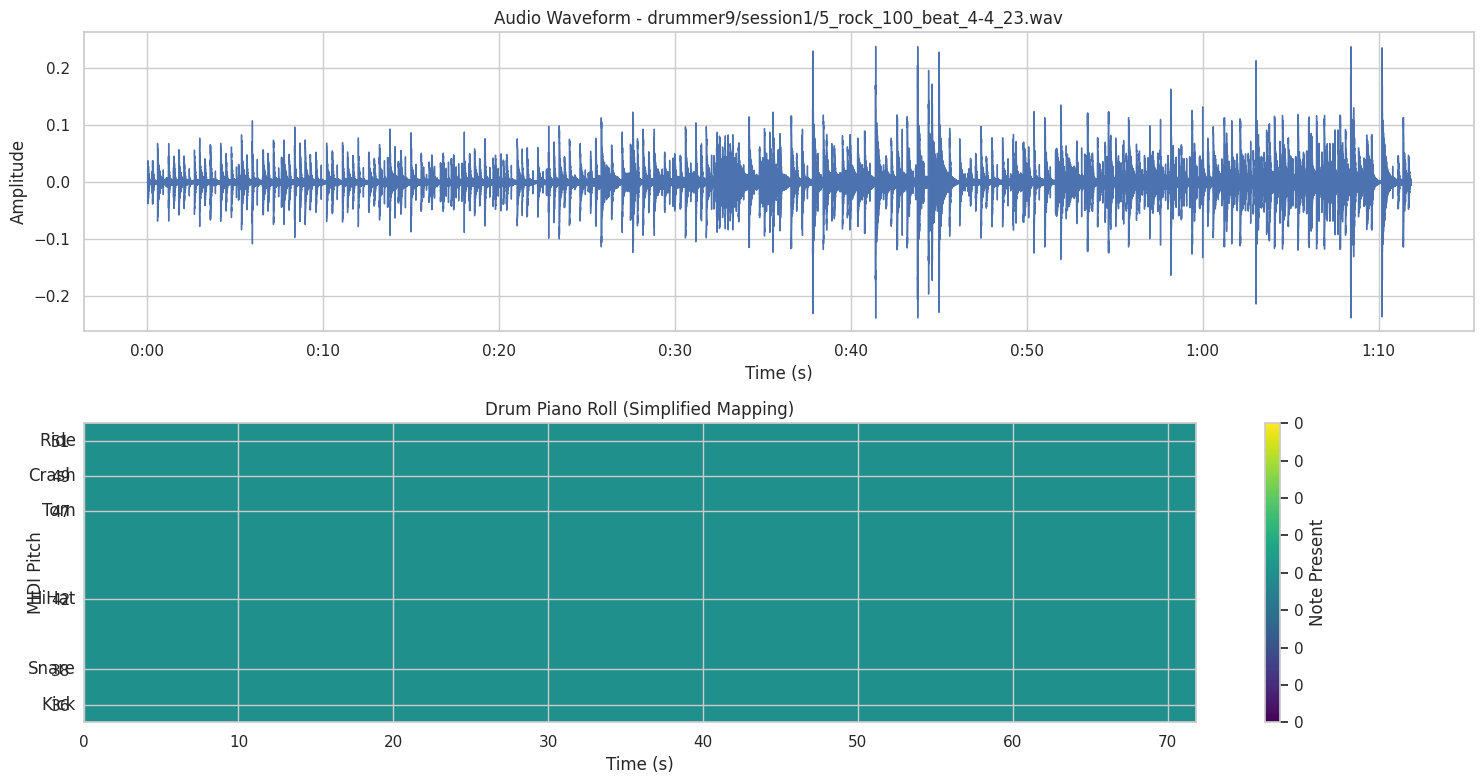


--- Visualizing Example 2316 ---
Drummer: drummer3, Style: rock, Tempo: 100.00 BPM, Split: train
Audio Path: ../data/subset/test/drummer3/session2/10_rock_100_beat_4-4_44.wav
MIDI Path: ../data/subset/test/drummer3/session2/10_rock_100_beat_4-4_44.midi

--- DETAILED MIDI ANALYSIS: 10_rock_100_beat_4-4_44.midi ---
✓ MIDI loaded successfully
  • Duration: 21.07 seconds
  • Time signature: [TimeSignature(numerator=4, denominator=4, time=0.0)]
  • Estimated tempo: 206.19 BPM
  • Resolution: 480 ticks per beat

INSTRUMENT TRACKS (1):

Track 0: 🥁 DRUM, Program: 0, Name: 'Midi Drums'
  • Contains 113 notes
  • Pitch range: 36 to 42
  • Most common pitches:
    - Pitch 42 (Closed Hi Hat): 74 notes
    - Pitch 38 (Acoustic Snare): 20 notes
    - Pitch 36 (Bass Drum 1): 19 notes
Audio loaded: duration=21.16s, sample_rate=44100Hz
MIDI loaded: estimated tempo=206.19 BPM
Detected drum hits:
  Kick (pitch 36): 19 hits
  Snare (pitch 38): 20 hits
  HiHat (pitch 42): 74 hits


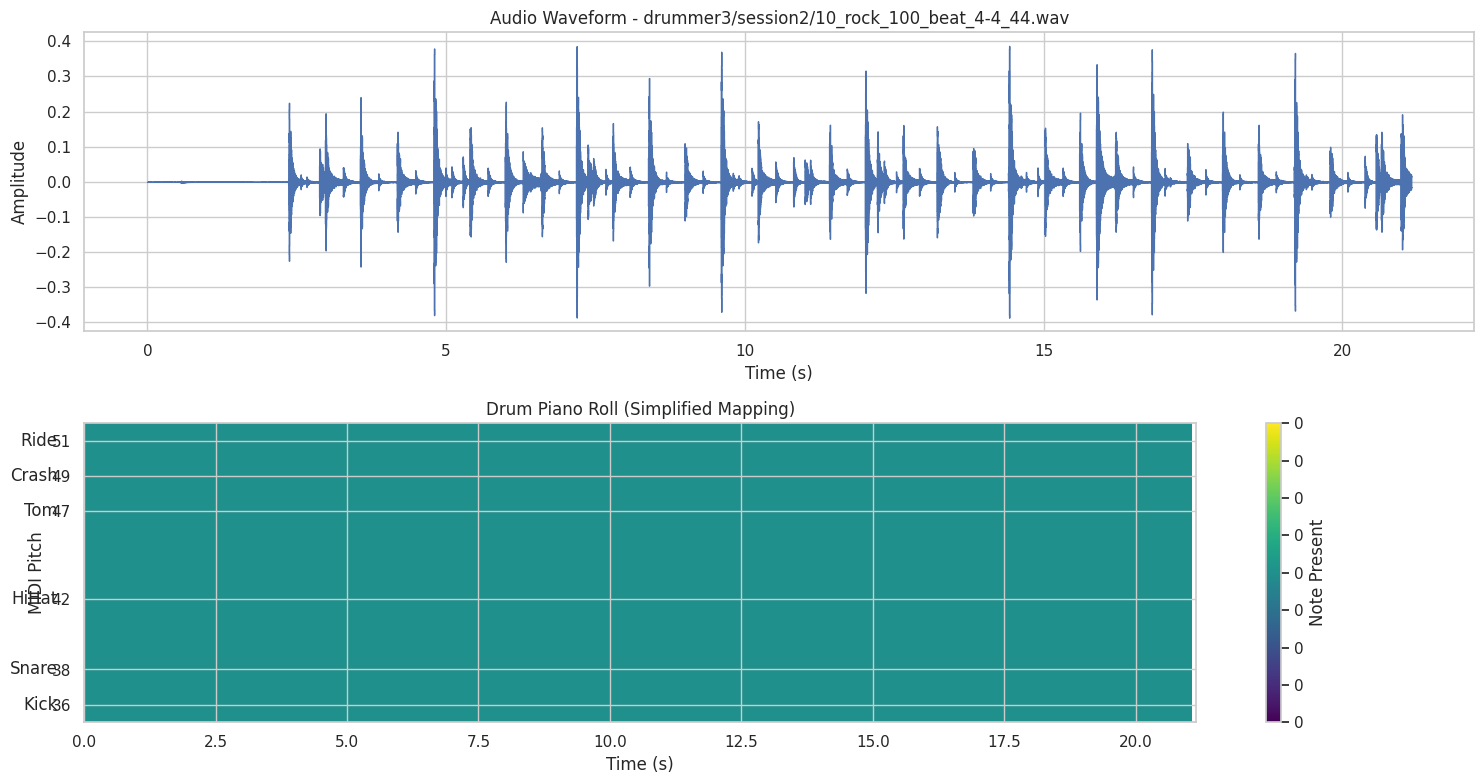

In [23]:
# Detailed MIDI inspection
def analyze_midi_file(midi_path):
    print(f"\n--- DETAILED MIDI ANALYSIS: {midi_path.name} ---")
    try:
        pm = pretty_midi.PrettyMIDI(str(midi_path))
        print("✓ MIDI loaded successfully")
        print(f"  • Duration: {pm.get_end_time():.2f} seconds")
        print(f"  • Time signature: {pm.time_signature_changes}")
        print(f"  • Estimated tempo: {pm.estimate_tempo():.2f} BPM")
        print(f"  • Resolution: {pm.resolution} ticks per beat")

        if not pm.instruments:
            print("⚠ WARNING: No instruments found in this MIDI file!")
            return pm

        print(f"\nINSTRUMENT TRACKS ({len(pm.instruments)}):")
        for i, instrument in enumerate(pm.instruments):
            drum_status = "🥁 DRUM" if instrument.is_drum else "🎹 Melodic"
            print(
                f"\nTrack {i}: {drum_status}, Program: {instrument.program}, Name: '{instrument.name}'"
            )

            if not instrument.notes:
                print("  • No notes in this track")
                continue

            note_count = len(instrument.notes)
            print(f"  • Contains {note_count} notes")

            # Find pitch range
            pitches = [note.pitch for note in instrument.notes]
            min_pitch, max_pitch = min(pitches), max(pitches)
            print(f"  • Pitch range: {min_pitch} to {max_pitch}")

            # Collect notes by pitch for statistics
            pitch_counts = {}
            for note in instrument.notes:
                if note.pitch not in pitch_counts:
                    pitch_counts[note.pitch] = 0
                pitch_counts[note.pitch] += 1

            # Print the 5 most common pitches
            top_pitches = sorted(
                pitch_counts.items(), key=lambda x: x[1], reverse=True
            )[:5]
            print("  • Most common pitches:")
            for pitch, count in top_pitches:
                try:
                    name = (
                        pretty_midi.note_number_to_drum_name(pitch)
                        if instrument.is_drum
                        else pretty_midi.note_number_to_name(pitch)
                    )
                except:
                    name = "Unknown"
                print(f"    - Pitch {pitch} ({name}): {count} notes")

        return pm
    except Exception as e:
        print(f"Error analyzing MIDI file: {e}")
        return None


if not df_subset.empty:
    # Select 2 random examples
    num_examples_to_show = 2
    random_indices = random.sample(range(len(df_subset)), num_examples_to_show)
    example_rows = df_subset.iloc[random_indices]

    for index, row in example_rows.iterrows():
        print(f"\n--- Visualizing Example {index} ---")
        # Use 'bpm' column for tempo display
        print(
            f"Drummer: {row['drummer']}, Style: {row['style']}, Tempo: {row['bpm']:.2f} BPM, Split: {row['split_set']}"
        )

        # Construct file paths
        # Path structure: SUBSET_DATA_DIR / split / audio_filename (which includes drummer/session/etc)
        audio_path: Path = SUBSET_DATA_DIR / row["split"] / row["audio_filename"]
        midi_path: Path = SUBSET_DATA_DIR / row["split"] / row["midi_filename"]

        print(f"Audio Path: {audio_path}")
        print(f"MIDI Path: {midi_path}")

        # Add this call before your visualization
        midi_for_analysis = analyze_midi_file(midi_path)

        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=None)  # Load with original sample rate
            print(
                f"Audio loaded: duration={librosa.get_duration(y=y, sr=sr):.2f}s, sample_rate={sr}Hz"
            )

            # Load MIDI
            pm = pretty_midi.PrettyMIDI(str(midi_path))
            print(f"MIDI loaded: estimated tempo={pm.estimate_tempo():.2f} BPM")

            # Create plots
            plt.figure(figsize=(15, 8))

            # Plot 1: Waveform
            plt.subplot(2, 1, 1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f"Audio Waveform - {row['audio_filename']}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")

            # Plot 2: Drum Piano Roll
            plt.subplot(2, 1, 2)
            plot_drum_piano_roll(
                pm, fs=sr
            )  # Use audio sample rate for fs in piano roll for alignment
            # Adjust x-axis limits to match waveform
            plt.xlim([0, librosa.get_duration(y=y, sr=sr)])
            plt.xlabel("Time (s)")

            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(
                f"Error: Audio or MIDI file not found for index {index}. Skipping visualization."
            )
            print(f"  Expected Audio: {audio_path}")
            print(f"  Expected MIDI: {midi_path}")
        except Exception as e:
            print(f"An error occurred processing index {index}: {e}")

else:
    print("Subset DataFrame is empty. Cannot visualize examples.")

## 9. Generate Subset Statistics

Finally, let's calculate and display some key statistics about our created subset to provide a final overview.

In [ ]:
if not df_subset.empty:
    print("--- Subset Statistics ---")

    # Total number of files
    total_files = len(df_subset)
    print(f"Total number of files (audio/MIDI pairs): {total_files}")

    # Total duration
    if "duration" in df_subset.columns:
        total_duration_seconds = df_subset["duration"].sum()
        total_duration_hours = total_duration_seconds / 3600
        print(
            f"Total duration of audio: {total_duration_seconds:.2f} seconds (~{total_duration_hours:.2f} hours)"
        )
    else:
        print(
            "Warning: 'duration' column not found in metadata. Cannot calculate total duration."
        )

else:
    print("Subset DataFrame is empty. Cannot generate statistics.")

### 9.1. Subset Distributions

Re-displaying the distributions for key features specifically for the subset.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if not df_subset.empty:
    # Columns to visualize
    categorical_cols_subset: typing.List[str] = [
        "drummer",
        "style",
        "time_signature",
        "split_set",
    ]
    # Use 'bpm' column for tempo visualization
    numerical_cols_subset: typing.List[str] = ["bpm", "duration"]

    print("\n--- Subset Categorical Distributions ---")
    for col in categorical_cols_subset:
        if col in df_subset.columns:
            plt.figure(figsize=(12, 5))
            sns.countplot(
                data=df_subset,
                y=col,
                order=df_subset[col].value_counts().index,
                palette="viridis",
            )
            plt.title(f"Distribution of '{col}' in Subset")
            plt.xlabel("Count")
            plt.ylabel(col.capitalize())
            plt.tight_layout()
            plt.show()
        else:
            print(f"Column '{col}' not found in subset metadata.")

    print("\n--- Subset Numerical Distributions ---")
    for col in numerical_cols_subset:
        if col in df_subset.columns:
            plt.figure(figsize=(10, 4))
            sns.histplot(df_subset[col], kde=True)
            plt.title(f"Distribution of '{col}' in Subset")
            plt.xlabel(col.capitalize())
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Column '{col}' not found for visualization.")

else:
    print("Subset DataFrame is empty, skipping distribution visualizations.")

**End of Notebook 1.**

We have successfully explored the E-GMD dataset, created a stratified 10% subset, copied the relevant files, split the subset into train/validation/test sets, visualized some examples, and generated final statistics. The subset metadata is saved in `data/subset/subset_metadata.csv`.